---

## **4. Methodology**

### **4.1 Overview of Experimental Procedure**

This study explores the fine-tuning of three variations of the Swin-Tiny Vision Transformer for a custom image classification task. The training procedure was designed to test how different levels of layer freezing, dropout regularization, and learning rate schedules affect model performance. All models were trained and evaluated under consistent conditions using a shared dataset and identical data loaders.

---

### **4.2 Dataset Preparation**

A dataset consisting of 700 original images across 7 classes was extended to approximately 4900 images through augmentation. Each image was named using a unique base identifier to retain the link between the original and its augmented variants.

To ensure robust evaluation and prevent data leakage, **group-wise splitting** was employed. Images were grouped based on their base identifier and then randomly assigned to one of the following splits:
- **Training Set**: 70%
- **Validation Set**: 15%
- **Test Set**: 15%

This approach ensured that all augmented versions of a given original image remained within the same split. During loading, each image was resized to **224×224 pixels** and normalized using standard **ImageNet mean and standard deviation** values.

---

### **4.3 Model Architecture and Training Configurations**

Three fine-tuned versions of the **Swin-Tiny (`swin_tiny_patch4_window7_224`)** model were developed using the `timm` library, trained with PyTorch. All models were configured for 7-class classification and underwent variations in their training strategies to evaluate transfer learning behavior.

#### **4.3.1 Version 1 (V1)**
- **Pretrained Weights**: Yes (ImageNet-1k)
- **Frozen Layers**: Patch embedding + first two hierarchical blocks
- **Classifier Head**: Original head
- **Optimizer**: AdamW (lr = 1e-4, weight decay = 1e-5)
- **Scheduler**: StepLR (step size = 5, gamma = 0.1)
- **Dropout**: Not used
- **Epochs**: 15

#### **4.3.2 Version 2 (V2)**
- **Pretrained Weights**: Custom weights from V1 (excluding classifier head)
- **Frozen Layers**: Patch embedding + first transformer block
- **Classifier Head**: Custom head with dropout (0.5) and spatial averaging
- **Optimizer**: AdamW with **layer-wise learning rates**  
  - Patch embed: 1e-5  
  - Transformer blocks: 3e-5  
  - Head: 1e-4
- **Scheduler**: CosineAnnealingLR (T_max = 15)
- **Dropout**: 0.5
- **Epochs**: 15

#### **4.3.3 Version 3 (V3)**
- **Pretrained Weights**: Custom weights from V2 (excluding classifier head)
- **Frozen Layers**: None (full model unfrozen)
- **Classifier Head**: Same as V2 (average pooling + dropout + linear)
- **Optimizer**: AdamW with same layer-wise learning rate strategy as V2
- **Scheduler**: CosineAnnealingLR (T_max = 15)
- **Dropout**: 0.5
- **Epochs**: 30
- **Early Stopping**: Patience of 30 epochs

---

### **4.4 Evaluation Protocol**

All versions were evaluated using the same **validation and test sets** to ensure consistent comparison. Performance metrics included:
- **Overall Accuracy**
- **Confusion Matrix**
- **Per-class Accuracy**
- **Loss and Accuracy Curves** (training vs. validation)

Evaluation metrics and training histories were visualized and saved for each model version. The best-performing model weights (based on validation loss) were retained using early stopping and checkpointing logic.

---

### **4.5 Model Saving and Artifact Management**

Each trained model version was saved in structured directories containing:
- The trained model weights (`.pth`)
- Training and validation history logs
- Evaluation metrics on the validation and test datasets
- Diagnostic visualizations (loss/accuracy curves, confusion matrix)

Artifacts were organized under:
```
Swin_Tiny/
    └── V1/
    └── V2/
    └── V3/
```

# Import Required Libraries

In [29]:
# Required libraries are imported.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from Utils.utils import evaluate_model, plotting, save_model_artifacts

In [55]:
import os
import json
import time
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, f1_score, roc_auc_score, roc_curve, auc,
    precision_recall_fscore_support, matthews_corrcoef, cohen_kappa_score,
    precision_recall_curve
)
from sklearn.preprocessing import label_binarize


def plotting(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss", marker="o", linestyle="-", color="blue")
    plt.plot(history["val_loss"], label="Validation Loss", marker="s", linestyle="-", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Training Accuracy", marker="o", linestyle="-", color="green")
    plt.plot(history["val_acc"], label="Validation Accuracy", marker="s", linestyle="-", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


def evaluate_model(model, dataloader, class_names, top_k=(1, 5), loader_name="Validation"):
    print(f"\nEvaluating model with {loader_name} loader.")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    top_k_correct = {k: 0 for k in top_k}
    total_samples = 0
    start_time = time.time()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            top_k_preds = torch.topk(outputs, max(top_k), dim=1).indices.cpu().numpy()

            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for k in top_k:
                top_k_correct[k] += np.sum(labels.cpu().numpy()[:, None] == top_k_preds[:, :k])
            total_samples += labels.size(0)

    inference_time = time.time() - start_time
    avg_inference_time = inference_time / total_samples

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    accuracy = np.trace(cm) / np.sum(cm) * 100
    error_rate = 100 - accuracy
    precision = np.diag(cm) / np.where(np.sum(cm, axis=0) == 0, 1, np.sum(cm, axis=0)) * 100
    recall = np.diag(cm) / np.where(np.sum(cm, axis=1) == 0, 1, np.sum(cm, axis=1)) * 100
    tn = np.sum(cm) - (np.sum(cm, axis=1) + np.sum(cm, axis=0) - np.diag(cm))
    fp = np.sum(cm, axis=0) - np.diag(cm)
    specificity = tn / np.where((tn + fp) == 0, 1, (tn + fp)) * 100

    f1_macro = f1_score(all_labels, all_preds, average="macro") * 100
    f1_weighted = f1_score(all_labels, all_preds, average="weighted") * 100
    f1_per_class = f1_score(all_labels, all_preds, average=None) * 100
    mcc = matthews_corrcoef(all_labels, all_preds) * 100
    kappa = cohen_kappa_score(all_labels, all_preds) * 100

    n_classes = len(class_names) if class_names is not None else np.max(all_labels) + 1
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]

    if n_classes > 1:
        all_labels_binarized = label_binarize(all_labels, classes=np.arange(n_classes))
        roc_auc = roc_auc_score(all_labels_binarized, all_probs, multi_class="ovr") * 100
    else:
        roc_auc = None

    top_k_accuracy = {f"Top-{k} Accuracy (%)": (top_k_correct[k] / total_samples) * 100 for k in top_k}

    unique_classes, support = np.unique(all_labels, return_counts=True)
    support_df = pd.DataFrame({
        "Class": class_names,
        "Support (Samples)": support
    })

    metrics_df = pd.DataFrame({
        "Class": class_names,
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1_per_class,
        "Specificity (%)": specificity
    }).round(2)

    print(f"\nOverall Accuracy: {accuracy:.2f}%")
    print(f"Overall Error Rate: {error_rate:.2f}%")
    print(f"F1-Score (Macro-Averaged): {f1_macro:.2f}%")
    print(f"F1-Score (Weighted): {f1_weighted:.2f}%")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}%")
    print(f"Cohen’s Kappa Score: {kappa:.2f}%")
    for k, acc in top_k_accuracy.items():
        print(f"{k}: {acc:.2f}%")
    print(f"\nAverage Inference Time per Image: {avg_inference_time:.6f} seconds")
    print("\nClass-Wise Performance Metrics:")
    print(metrics_df.to_string(index=False))
    print("\nClass-Wise Sample Distribution:")
    print(support_df.to_string(index=False))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    if roc_auc is not None:
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
            roc_auc_val = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc_val:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 6))
    for class_idx, class_name in enumerate(class_names):
        y_true = (all_labels == class_idx).astype(int)
        y_scores = (all_preds == class_idx).astype(int)
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall_curve, precision_curve)
        plt.plot(recall_curve, precision_curve, label=f"{class_name} (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": round(accuracy, 2),
        "error_rate": round(error_rate, 2),
        "f1_macro": round(f1_macro, 2),
        "f1_weighted": round(f1_weighted, 2),
        "roc_auc": round(roc_auc, 2) if roc_auc is not None else "N/A",
        "mcc": round(mcc, 2),
        "kappa": round(kappa, 2),
        "top_k_accuracy": top_k_accuracy,
        "avg_inference_time": avg_inference_time,
        "class_metrics": metrics_df.to_dict(orient="records"),
        "class_support": support_df.to_dict(orient="records")
    }


def save_model_artifacts(
    model,
    history,
    metrics,
    model_name="model",
    version="V1",
    base_dir="/Users/tahfimibnkhan/Desktop/ViT_Final"
):
    """
    Saves model, training metrics, and evaluation metrics in a structured format.

    Args:
        model (torch.nn.Module): Trained model to save.
        history (dict): Training history with 'train_loss', 'train_acc', 'val_loss', 'val_acc'.
        metrics (dict): Evaluation metrics dictionary.
        model_name (str): Name of the model (e.g., "deit_small", "mobilevit", etc.).
        version (str): Version identifier (e.g., "V1", "V2").
        base_dir (str): Base directory to save all artifacts.
    """
    # Save training metrics
    logs_dir = os.path.join(base_dir, "RESULTS", "logs")
    os.makedirs(logs_dir, exist_ok=True)

    training_metrics = {
        "train_loss": history["train_loss"][-1],
        "train_acc": history["train_acc"][-1],
        "val_loss": history["val_loss"][-1],
        "val_acc": history["val_acc"][-1]
    }

    training_metrics_path = os.path.join(logs_dir, f"{model_name}_training_metrics_{version}.json")
    with open(training_metrics_path, "w") as f:
        json.dump(training_metrics, f, indent=4)
    print(f"Training metrics logged to {training_metrics_path}")

    # Save model
    model_dir = os.path.join(base_dir, "MODELS", model_name)
    os.makedirs(model_dir, exist_ok=True)
    model.to("cpu")
    model_path = os.path.join(model_dir, f"{model_name}_{version}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save evaluation metrics
    eval_dir = os.path.join(base_dir, "RESULTS", "evaluation_logs")
    os.makedirs(eval_dir, exist_ok=True)

    eval_metrics_path = os.path.join(eval_dir, f"{model_name}_evaluation_metrics_{version}.json")
    with open(eval_metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"Evaluation metrics saved at: {eval_metrics_path}")

    # Save class-wise metrics
    class_metrics = metrics.get("Class-Wise Metrics") or metrics.get("class_metrics")
    if class_metrics:
        class_metrics_df = pd.DataFrame(class_metrics)
        class_metrics_path = os.path.join(eval_dir, f"{model_name}_class_wise_metrics_{version}.csv")
        class_metrics_df.to_csv(class_metrics_path, index=False)
        print(f"Class-wise metrics saved at: {class_metrics_path}")
    else:
        print("No class-wise metrics found in evaluation results.")

# Define Dataset Path and Transformations

In [30]:
# The dataset path is defined.
dataset_path = "/Users/tahfimibnkhan/Desktop/ViT/DATASET/AUGMENTED_DATASET"

# Transformations are applied to the images.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading the Dataset

In [31]:
# The dataset is loaded using ImageFolder.
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# The number of classes in the dataset is obtained.
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 7


# Splitting the Dataset into Training and Validation Sets 85-15

In [32]:
import os
import random
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

# Groups of images were prepared using base image identifiers
image_groups = {}
for img_path, _ in dataset.samples:
    filename = os.path.basename(img_path)
    original_id = "_".join(filename.split("_")[:-1])  # Base ID was extracted before augmentation tags
    if original_id not in image_groups:
        image_groups[original_id] = []
    image_groups[original_id].append(img_path)

# Group keys were shuffled to ensure random distribution
random.seed(42)
group_keys = list(image_groups.keys())
random.shuffle(group_keys)

# The dataset was split into training (70%), validation (15%), and test (15%) sets
total = len(group_keys)
train_size = round(0.70 * total)
val_size = round(0.15 * total)
test_size = total - train_size - val_size

train_keys = set(group_keys[:train_size])
val_keys = set(group_keys[train_size:train_size + val_size])
test_keys = set(group_keys[train_size + val_size:])

# Indices were assigned to the appropriate split based on the group identifier
train_indices, val_indices, test_indices = [], [], []

for idx, (img_path, _) in enumerate(dataset.samples):
    filename = os.path.basename(img_path)
    original_id = "_".join(filename.split("_")[:-1])
    if original_id in train_keys:
        train_indices.append(idx)
    elif original_id in val_keys:
        val_indices.append(idx)
    elif original_id in test_keys:
        test_indices.append(idx)

# Subsets were created for each split
train_data = Subset(dataset, train_indices)
val_data = Subset(dataset, val_indices)
test_data = Subset(dataset, test_indices)

# Data loaders were initialized for model1training and evaluation
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 3462
Validation samples: 709
Test samples: 729


# Loading the Swin-Tiny Model

In [33]:
import timm
import torch

num_classes = 7  # Define the number of target classes.

# The Swin-Tiny model is loaded from timm with pre-trained weights.
model1 = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)

# The patch embedding layer is frozen to retain pre-trained features.
for param in model1.patch_embed.parameters():
    param.requires_grad = False  # Patch embedding is frozen.

# The first two hierarchical layers are correctly accessed and frozen.
for i in range(2):  # Access each layer explicitly
    for param in model1.layers[i].parameters():
        param.requires_grad = False  

# The device (CPU or GPU) is determined.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The model is moved to the selected device.
model1.to(device)

print(f"Model loaded, early layers frozen, and moved to {device}")

Model loaded, early layers frozen, and moved to cpu


# Defining Loss Function and Optimizer

In [34]:
# The loss function is defined.
criterion = nn.CrossEntropyLoss()

# The AdamW optimizer is used.
optimizer = optim.AdamW(model1.parameters(), lr=1e-4, weight_decay=1e-5)

# A learning rate scheduler is added to adjust the learning rate over time.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


# Defining the Training Loop

In [35]:
def train1(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15):
    # A dictionary is created to store training history.
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        # The model is set to training mode.
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # Training loop is started.
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # The model is set to evaluation mode.
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        # Validation loop is started.
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # The learning rate scheduler is updated.
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

    return history

# The model is trained and history is obtained.
history1 = train1(model1, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15)

Epoch 1/15: 100%|█████████████████████████████| 109/109 [07:25<00:00,  4.08s/it]


Epoch 1/15: Train Loss: 0.5609, Train Acc: 79.55% | Val Loss: 0.1993, Val Acc: 92.52%



Epoch 2/15: 100%|█████████████████████████████| 109/109 [06:55<00:00,  3.82s/it]


Epoch 2/15: Train Loss: 0.1657, Train Acc: 94.57% | Val Loss: 0.1022, Val Acc: 95.77%



Epoch 3/15: 100%|█████████████████████████████| 109/109 [07:47<00:00,  4.29s/it]


Epoch 3/15: Train Loss: 0.0582, Train Acc: 97.89% | Val Loss: 0.1722, Val Acc: 94.22%



Epoch 4/15: 100%|█████████████████████████████| 109/109 [08:12<00:00,  4.52s/it]


Epoch 4/15: Train Loss: 0.0511, Train Acc: 98.47% | Val Loss: 0.1557, Val Acc: 95.49%



Epoch 5/15: 100%|█████████████████████████████| 109/109 [11:50<00:00,  6.52s/it]


Epoch 5/15: Train Loss: 0.0615, Train Acc: 98.12% | Val Loss: 0.0982, Val Acc: 96.61%



Epoch 6/15: 100%|█████████████████████████████| 109/109 [12:10<00:00,  6.71s/it]


Epoch 6/15: Train Loss: 0.0258, Train Acc: 99.36% | Val Loss: 0.0816, Val Acc: 97.46%



Epoch 7/15: 100%|█████████████████████████████| 109/109 [13:55<00:00,  7.67s/it]


Epoch 7/15: Train Loss: 0.0141, Train Acc: 99.74% | Val Loss: 0.0879, Val Acc: 97.88%



Epoch 8/15: 100%|█████████████████████████████| 109/109 [14:10<00:00,  7.81s/it]


Epoch 8/15: Train Loss: 0.0080, Train Acc: 99.94% | Val Loss: 0.0886, Val Acc: 98.03%



Epoch 9/15: 100%|█████████████████████████████| 109/109 [13:37<00:00,  7.50s/it]


Epoch 9/15: Train Loss: 0.0069, Train Acc: 99.88% | Val Loss: 0.1000, Val Acc: 97.88%



Epoch 10/15: 100%|████████████████████████████| 109/109 [14:52<00:00,  8.19s/it]


Epoch 10/15: Train Loss: 0.0049, Train Acc: 99.91% | Val Loss: 0.0926, Val Acc: 97.60%



Epoch 11/15: 100%|████████████████████████████| 109/109 [13:27<00:00,  7.41s/it]


Epoch 11/15: Train Loss: 0.0046, Train Acc: 99.91% | Val Loss: 0.0946, Val Acc: 97.60%



Epoch 12/15: 100%|████████████████████████████| 109/109 [15:35<00:00,  8.58s/it]


Epoch 12/15: Train Loss: 0.0063, Train Acc: 99.80% | Val Loss: 0.0931, Val Acc: 97.60%



Epoch 13/15: 100%|████████████████████████████| 109/109 [15:00<00:00,  8.26s/it]


Epoch 13/15: Train Loss: 0.0044, Train Acc: 99.97% | Val Loss: 0.0932, Val Acc: 97.60%



Epoch 14/15: 100%|████████████████████████████| 109/109 [16:40<00:00,  9.18s/it]


Epoch 14/15: Train Loss: 0.0050, Train Acc: 99.86% | Val Loss: 0.0918, Val Acc: 97.60%



Epoch 15/15: 100%|████████████████████████████| 109/109 [13:51<00:00,  7.63s/it]


Epoch 15/15: Train Loss: 0.0047, Train Acc: 99.88% | Val Loss: 0.0919, Val Acc: 97.60%



# Visualizing Training & Validation Performance

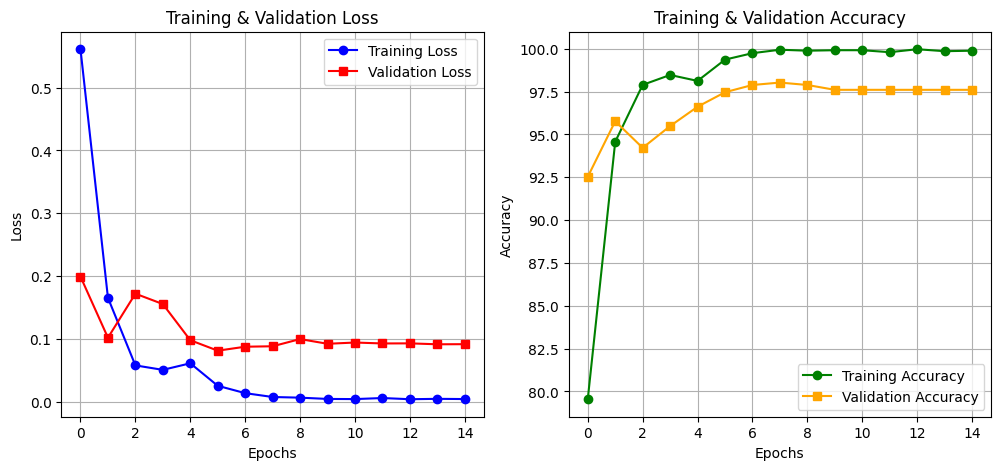


Evaluating model with Validation loader.

Overall Accuracy: 97.60%
Overall Error Rate: 2.40%
F1-Score (Macro-Averaged): 97.67%
F1-Score (Weighted): 97.60%
Matthews Correlation Coefficient (MCC): 97.20%
Cohen’s Kappa Score: 97.20%
Top-1 Accuracy (%): 97.60%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.046084 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          97.17       92.79         94.93            99.50
 BRRI_28          98.89       98.89         98.89            99.84
 BRRI_29          94.78       98.20         96.46            99.00
 BRRI_34          96.33       98.13         97.22            99.34
 BRRI_50          97.59       98.78         98.18            99.68
 BRRI_74          99.07      100.00         99.53            99.83
    BR_5         100.00       97.03         98.49           100.00

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                111
 BRR

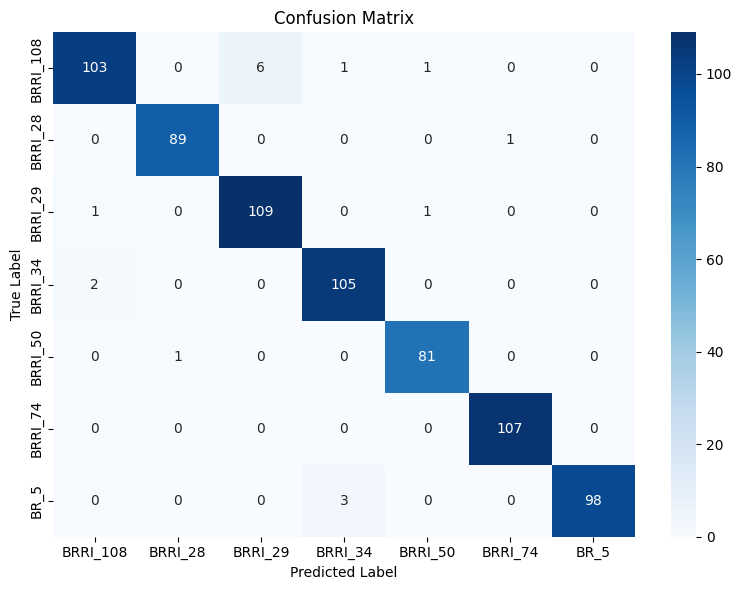

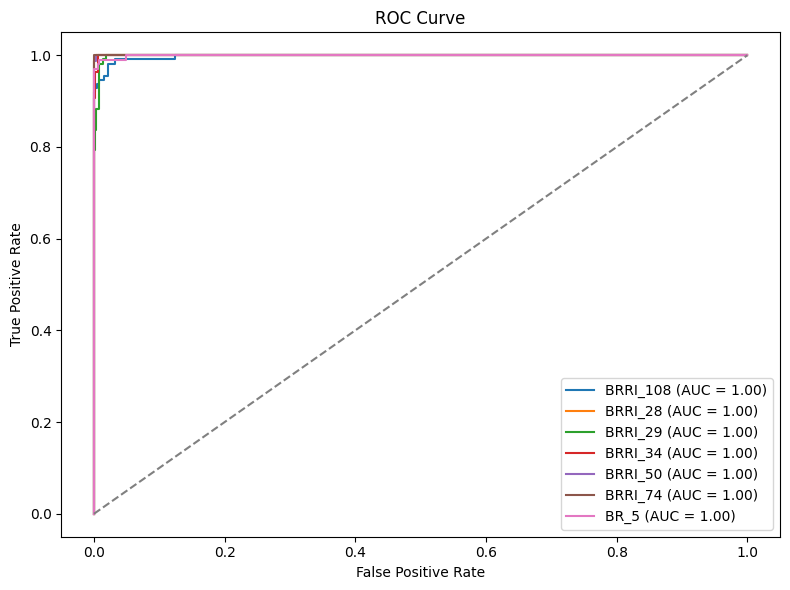

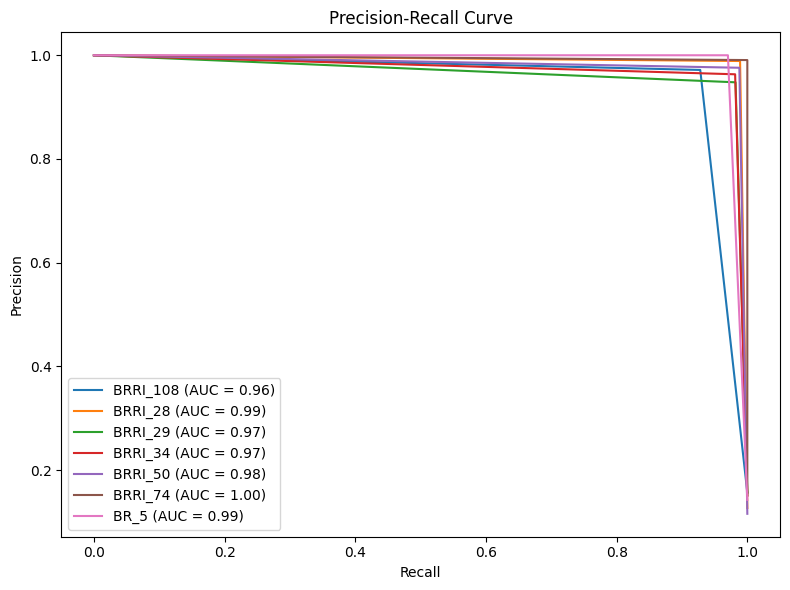


Evaluating model with Testing loader.

Overall Accuracy: 96.84%
Overall Error Rate: 3.16%
F1-Score (Macro-Averaged): 96.87%
F1-Score (Weighted): 96.85%
Matthews Correlation Coefficient (MCC): 96.33%
Cohen’s Kappa Score: 96.31%
Top-1 Accuracy (%): 96.84%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.044443 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          98.20       93.16         95.61            99.67
 BRRI_28          97.48       96.67         97.07            99.51
 BRRI_29          91.92       98.91         95.29            98.74
 BRRI_34          94.69       98.17         96.40            99.03
 BRRI_50          99.06       97.22         98.13            99.84
 BRRI_74          96.81      100.00         98.38            99.53
    BR_5         100.00       94.57         97.21           100.00

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                117
 BRRI_2

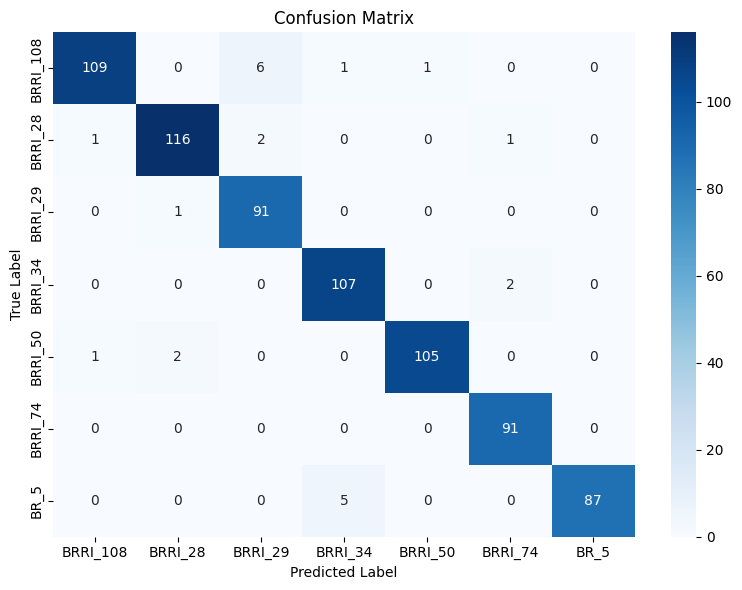

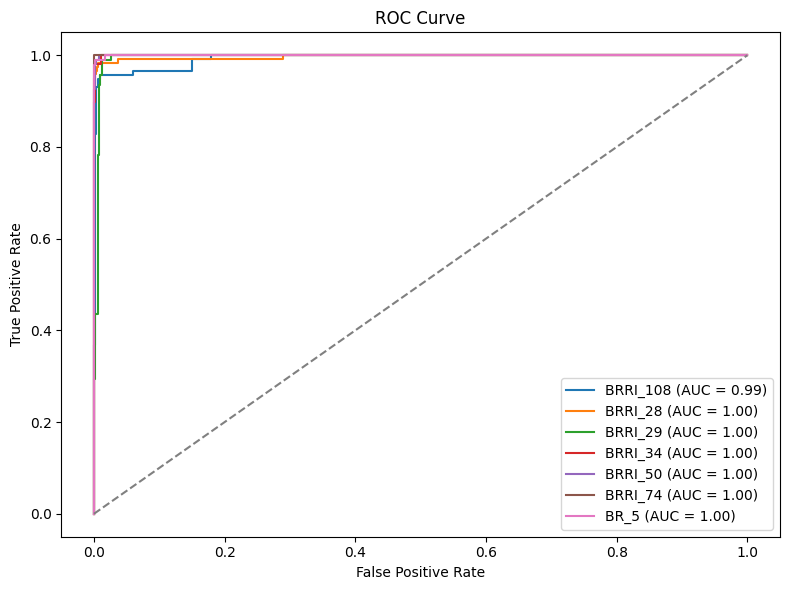

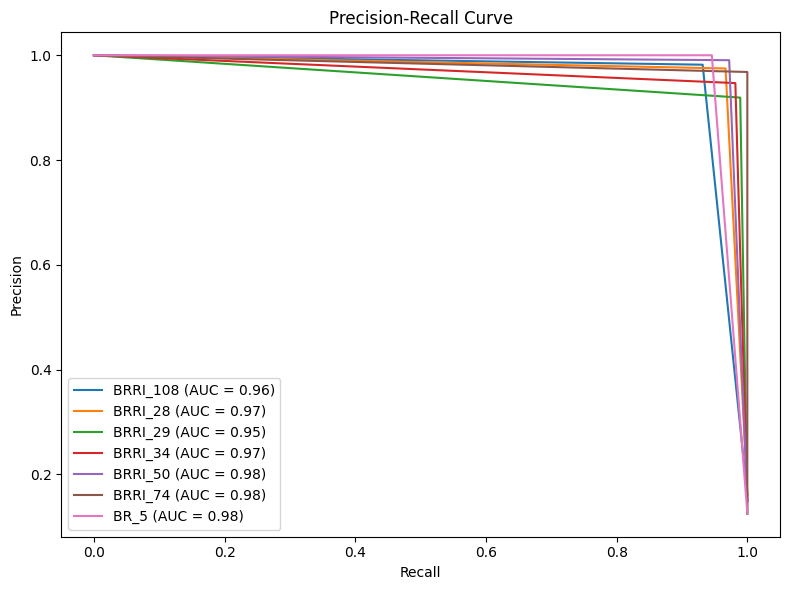

Training metrics logged to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/logs/swin_tiny_training_metrics_1.json
Model saved to /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/swin_tiny/swin_tiny_1.pth
Evaluation metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/swin_tiny_evaluation_metrics_1.json
Class-wise metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/swin_tiny_class_wise_metrics_1.csv


In [56]:
plottting1=plotting(history1)
metrics1=evaluate_model(model1, val_loader, class_names=dataset.classes, loader_name="Validation")
metrics1=evaluate_model(model1, test_loader, class_names=dataset.classes, loader_name="Testing")
save_model_artifacts(model=model1,history=history1,metrics=metrics1,model_name="swin_tiny",version="1")

# Version 2

In [43]:
import timm
import torch
import torch.nn as nn

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of classes
num_classes = 7  # Replace with your actual number of classes

# Load the Swin-Tiny model
model2 = timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, num_classes=num_classes)

# Load trained model weights
model_path = "/Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/swin_tiny/swin_tiny_1.pth"
model2.load_state_dict(torch.load(model_path, map_location=device))
model2.to(device)

# Freeze the patch embedding layer
for param in model2.patch_embed.parameters():  
    param.requires_grad = False  

# Freeze the first transformer layer, while keeping deeper layers trainable
for i in range(1):
    for param in model2.layers[i].parameters():
        param.requires_grad = False

# Extract input feature dimension from the original head
in_features = model2.head.in_features  # Expected to be 768

# Fix classification head to handle Swin-Tiny's sequence output
class SwinFixHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super(SwinFixHead, self).__init__()
        self.dropout = nn.Dropout(0.5)  # Regularization
        self.fc = nn.Linear(in_features, num_classes)  # Fully connected layer

    def forward(self, x):
        # Handle Swin-Tiny output shape: [batch_size, height, width, feature_dim]
        if x.dim() == 4:  # If input is [B, H, W, C]
            batch_size, height, width, feature_dim = x.shape
            x = x.view(batch_size, height * width, feature_dim)  # Reshape to [B, Seq_Len, C]
            x = x.mean(1)  # Average over sequence length to get [B, C]
        else:
            raise ValueError(f"Unexpected input shape {x.shape}")

        x = self.dropout(x)
        return self.fc(x)

# Assign the corrected classification head
model2.head = SwinFixHead(in_features, num_classes)

# Ensure classification head is trainable
for param in model2.head.parameters():  
    param.requires_grad = True  

print(f"Model loaded, deeper layers are unfrozen for fine-tuning, and moved to {device}")

Model loaded, deeper layers are unfrozen for fine-tuning, and moved to cpu


In [44]:
import torch.optim as optim
import torch.nn as nn

# The loss function is defined.
criterion = nn.CrossEntropyLoss()

# Optimizer with layer-wise learning rate decay (LWR)
optimizer = optim.AdamW([
    {'params': model2.patch_embed.parameters(), 'lr': 1e-5},
    {'params': model2.layers.parameters(), 'lr': 3e-5},
    {'params': model2.head.parameters(), 'lr': 1e-4}
], weight_decay=5e-5)

# Learning rate scheduler (choosing Cosine Annealing for smooth decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

print("Loss function, optimizer, and learning rate scheduler have been defined.")

Loss function, optimizer, and learning rate scheduler have been defined.


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train2(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    best_val_loss = float("inf")  
    counter = 0  

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            labels = labels.view(-1) 
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            predicted = torch.argmax(outputs, dim=1)  # Explicit method
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                predicted = torch.argmax(outputs, dim=1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)  # Reduce LR on plateau
        else:
            scheduler.step()  # Cosine Annealing or StepLR

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0  
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': best_val_loss
            }, "swin1_best_model.pth")
            print("Model improved and saved.")
        else:
            counter += 1  
            print(f"Early Stopping Counter: {counter}/{patience}")

            if counter >= patience:
                print("Early stopping triggered. Training has been stopped.")
                break  

    return history

# Training the Swin-Tiny model
history2 = train2(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15, patience=15)

Epoch 1/15: 100%|█████████████████████████████| 109/109 [07:37<00:00,  4.19s/it]


Epoch 1/15: Train Loss: 0.0065, Train Acc: 99.91% | Val Loss: 0.1226, Val Acc: 96.61%
Model improved and saved.


Epoch 2/15: 100%|█████████████████████████████| 109/109 [07:55<00:00,  4.36s/it]


Epoch 2/15: Train Loss: 0.0068, Train Acc: 99.83% | Val Loss: 0.1226, Val Acc: 96.61%
Early Stopping Counter: 1/15


Epoch 3/15: 100%|█████████████████████████████| 109/109 [07:30<00:00,  4.14s/it]


Epoch 3/15: Train Loss: 0.0061, Train Acc: 99.94% | Val Loss: 0.1226, Val Acc: 96.61%
Early Stopping Counter: 2/15


Epoch 4/15: 100%|█████████████████████████████| 109/109 [07:13<00:00,  3.97s/it]


Epoch 4/15: Train Loss: 0.0073, Train Acc: 99.86% | Val Loss: 0.1226, Val Acc: 96.61%
Early Stopping Counter: 3/15


Epoch 5/15: 100%|█████████████████████████████| 109/109 [06:31<00:00,  3.59s/it]


Epoch 5/15: Train Loss: 0.0075, Train Acc: 99.86% | Val Loss: 0.1226, Val Acc: 96.61%
Early Stopping Counter: 4/15


Epoch 6/15: 100%|█████████████████████████████| 109/109 [06:42<00:00,  3.70s/it]


Epoch 6/15: Train Loss: 0.0084, Train Acc: 99.77% | Val Loss: 0.1226, Val Acc: 96.61%
Early Stopping Counter: 5/15


Epoch 7/15: 100%|█████████████████████████████| 109/109 [07:01<00:00,  3.87s/it]


Epoch 7/15: Train Loss: 0.0061, Train Acc: 99.97% | Val Loss: 0.1226, Val Acc: 96.61%
Early Stopping Counter: 6/15


Epoch 8/15: 100%|█████████████████████████████| 109/109 [07:03<00:00,  3.88s/it]


Epoch 8/15: Train Loss: 0.0060, Train Acc: 99.86% | Val Loss: 0.1226, Val Acc: 96.61%
Early Stopping Counter: 7/15


Epoch 9/15: 100%|█████████████████████████████| 109/109 [07:03<00:00,  3.88s/it]


Epoch 9/15: Train Loss: 0.0086, Train Acc: 99.71% | Val Loss: 0.1226, Val Acc: 96.61%
Early Stopping Counter: 8/15


Epoch 10/15: 100%|████████████████████████████| 109/109 [07:36<00:00,  4.18s/it]


Epoch 10/15: Train Loss: 0.0064, Train Acc: 99.91% | Val Loss: 0.1226, Val Acc: 96.61%
Early Stopping Counter: 9/15


Epoch 11/15: 100%|████████████████████████████| 109/109 [09:17<00:00,  5.11s/it]


Epoch 11/15: Train Loss: 0.0056, Train Acc: 99.94% | Val Loss: 0.1226, Val Acc: 96.61%
Early Stopping Counter: 10/15


Epoch 12/15: 100%|████████████████████████████| 109/109 [08:38<00:00,  4.75s/it]


Epoch 12/15: Train Loss: 0.0056, Train Acc: 99.88% | Val Loss: 0.1226, Val Acc: 96.61%
Early Stopping Counter: 11/15


Epoch 13/15: 100%|████████████████████████████| 109/109 [10:25<00:00,  5.74s/it]


Epoch 13/15: Train Loss: 0.0084, Train Acc: 99.86% | Val Loss: 0.1226, Val Acc: 96.61%
Early Stopping Counter: 12/15


Epoch 14/15: 100%|████████████████████████████| 109/109 [13:10<00:00,  7.25s/it]


Epoch 14/15: Train Loss: 0.0077, Train Acc: 99.88% | Val Loss: 0.1226, Val Acc: 96.61%
Early Stopping Counter: 13/15


Epoch 15/15: 100%|████████████████████████████| 109/109 [08:18<00:00,  4.58s/it]


Epoch 15/15: Train Loss: 0.0079, Train Acc: 99.91% | Val Loss: 0.1226, Val Acc: 96.61%
Early Stopping Counter: 14/15


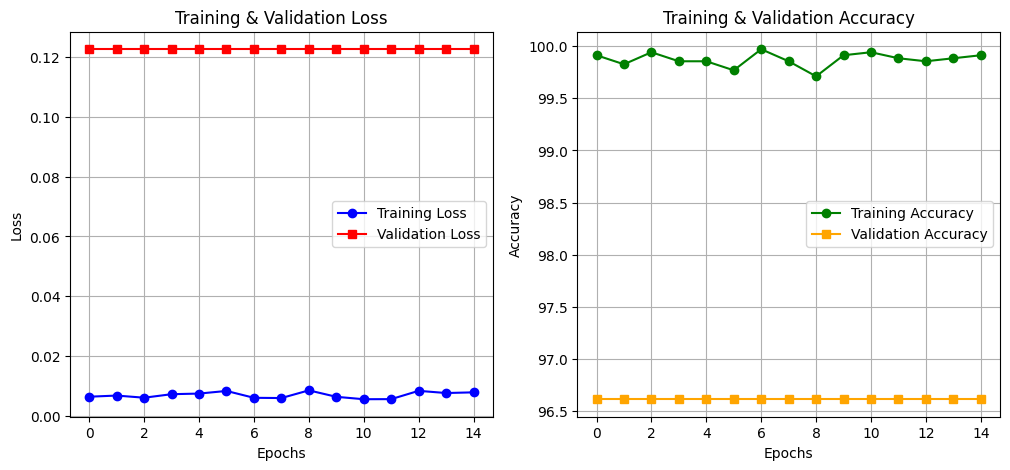


Evaluating model with Validation loader.

Overall Accuracy: 16.78%
Overall Error Rate: 83.22%
F1-Score (Macro-Averaged): 12.55%
F1-Score (Weighted): 13.17%
Matthews Correlation Coefficient (MCC): 2.71%
Cohen’s Kappa Score: 2.56%
Top-1 Accuracy (%): 16.78%
Top-5 Accuracy (%): 65.87%

Average Inference Time per Image: 0.046807 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108           0.00        0.00          0.00            96.49
 BRRI_28          10.71        6.67          8.22            91.92
 BRRI_29          16.30       27.03         20.34            74.25
 BRRI_34          47.98       77.57         59.29            85.05
 BRRI_50           0.00        0.00          0.00            93.46
 BRRI_74           0.00        0.00          0.00            98.01
    BR_5           0.00        0.00          0.00            63.49

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                111
 BRRI_

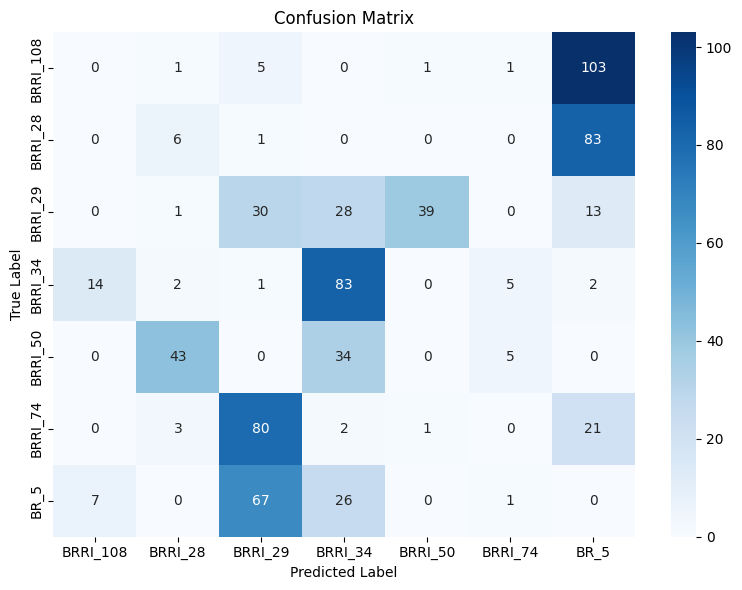

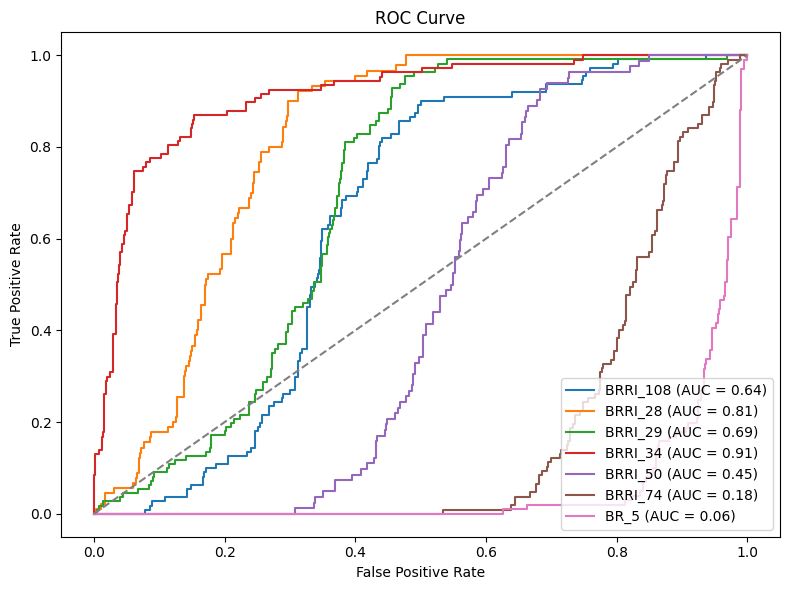

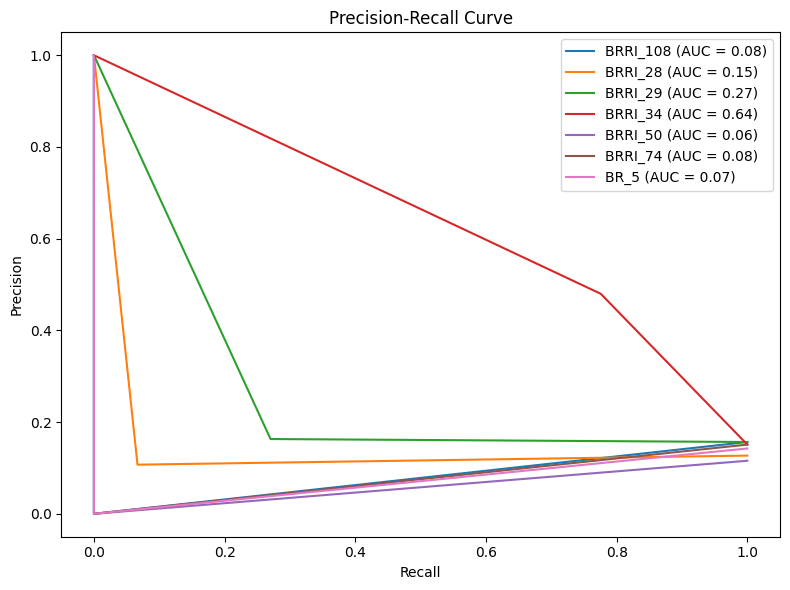


Evaluating model with Testing loader.

Overall Accuracy: 14.27%
Overall Error Rate: 85.73%
F1-Score (Macro-Averaged): 11.64%
F1-Score (Weighted): 11.86%
Matthews Correlation Coefficient (MCC): 0.70%
Cohen’s Kappa Score: 0.65%
Top-1 Accuracy (%): 14.27%
Top-5 Accuracy (%): 68.72%

Average Inference Time per Image: 0.051032 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108           4.00        0.85          1.41            96.08
 BRRI_28           6.41        4.17          5.05            88.01
 BRRI_29          13.77       25.00         17.76            77.39
 BRRI_34          49.02       68.81         57.25            87.42
 BRRI_50           0.00        0.00          0.00            96.30
 BRRI_74           0.00        0.00          0.00            97.96
    BR_5           0.00        0.00          0.00            57.61

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                117
 BRRI_28 

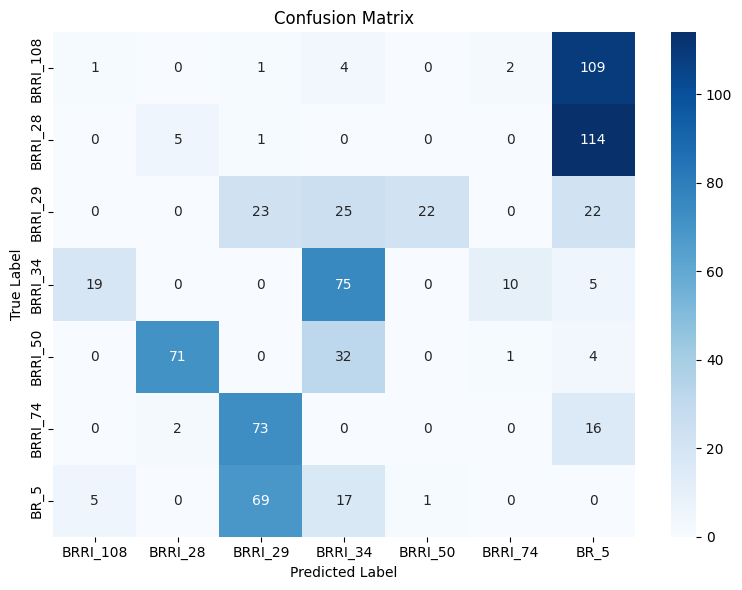

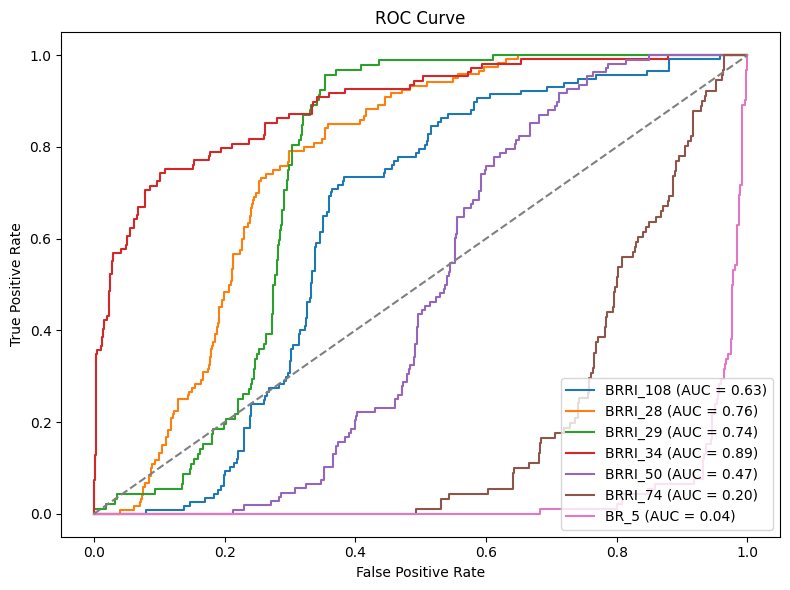

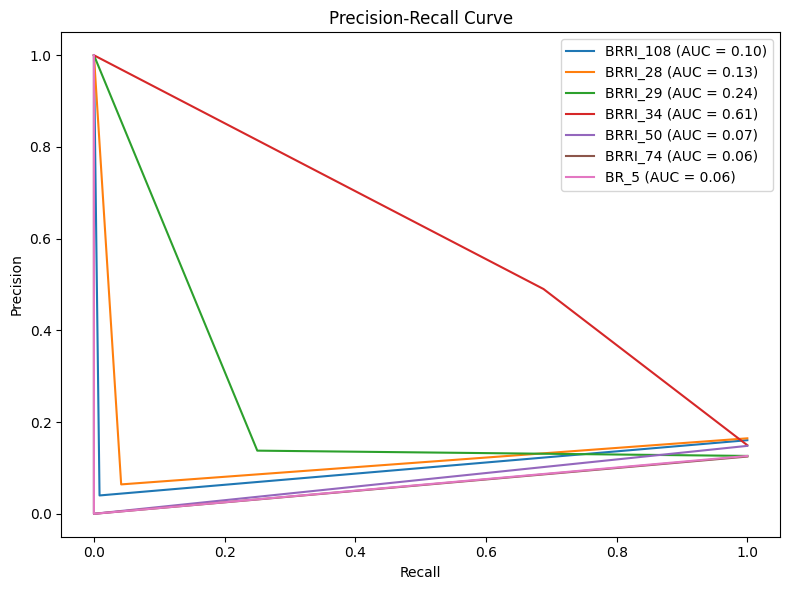

Training metrics logged to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/logs/swin_tiny_training_metrics_2.json
Model saved to /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/swin_tiny/swin_tiny_2.pth
Evaluation metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/swin_tiny_evaluation_metrics_2.json
Class-wise metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/swin_tiny_class_wise_metrics_2.csv


In [53]:
def evaluate_model(model, dataloader, class_names, top_k=(1, 5), loader_name="Validation"):
    print(f"\nEvaluating model with {loader_name} loader.")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    top_k_correct = {k: 0 for k in top_k}
    total_samples = 0
    start_time = time.time()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Apply pooling if model output is sequence-shaped (e.g., Swin Tiny)
            if outputs.dim() == 3:
                outputs = torch.mean(outputs, dim=1)

            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            top_k_preds = torch.topk(outputs, max(top_k), dim=1).indices.cpu().numpy()

            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for k in top_k:
                correct_top_k = np.sum(
                    labels.cpu().numpy().reshape(-1, 1) == top_k_preds[:, :k]
                )
                top_k_correct[k] += correct_top_k

            total_samples += labels.size(0)

    inference_time = time.time() - start_time
    avg_inference_time = inference_time / total_samples

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    from sklearn.metrics import (
        confusion_matrix, f1_score, roc_auc_score, roc_curve, auc,
        matthews_corrcoef, cohen_kappa_score, precision_recall_curve
    )
    from sklearn.preprocessing import label_binarize
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    cm = confusion_matrix(all_labels, all_preds)
    accuracy = np.trace(cm) / np.sum(cm) * 100
    error_rate = 100 - accuracy
    precision = np.diag(cm) / np.where(np.sum(cm, axis=0) == 0, 1, np.sum(cm, axis=0)) * 100
    recall = np.diag(cm) / np.where(np.sum(cm, axis=1) == 0, 1, np.sum(cm, axis=1)) * 100
    tn = np.sum(cm) - (np.sum(cm, axis=1) + np.sum(cm, axis=0) - np.diag(cm))
    fp = np.sum(cm, axis=0) - np.diag(cm)
    specificity = tn / np.where((tn + fp) == 0, 1, (tn + fp)) * 100

    f1_macro = f1_score(all_labels, all_preds, average="macro") * 100
    f1_weighted = f1_score(all_labels, all_preds, average="weighted") * 100
    f1_per_class = f1_score(all_labels, all_preds, average=None) * 100
    mcc = matthews_corrcoef(all_labels, all_preds) * 100
    kappa = cohen_kappa_score(all_labels, all_preds) * 100

    n_classes = len(class_names) if class_names is not None else np.max(all_labels) + 1
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]

    if n_classes > 1:
        all_labels_binarized = label_binarize(all_labels, classes=np.arange(n_classes))
        roc_auc = roc_auc_score(all_labels_binarized, all_probs, multi_class="ovr") * 100
    else:
        roc_auc = None

    top_k_accuracy = {f"Top-{k} Accuracy (%)": (top_k_correct[k] / total_samples) * 100 for k in top_k}

    unique_classes, support = np.unique(all_labels, return_counts=True)
    support_df = pd.DataFrame({
        "Class": class_names,
        "Support (Samples)": support
    })

    metrics_df = pd.DataFrame({
        "Class": class_names,
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1_per_class,
        "Specificity (%)": specificity
    }).round(2)

    print(f"\nOverall Accuracy: {accuracy:.2f}%")
    print(f"Overall Error Rate: {error_rate:.2f}%")
    print(f"F1-Score (Macro-Averaged): {f1_macro:.2f}%")
    print(f"F1-Score (Weighted): {f1_weighted:.2f}%")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}%")
    print(f"Cohen’s Kappa Score: {kappa:.2f}%")
    for k, acc in top_k_accuracy.items():
        print(f"{k}: {acc:.2f}%")
    print(f"\nAverage Inference Time per Image: {avg_inference_time:.6f} seconds")
    print("\nClass-Wise Performance Metrics:")
    print(metrics_df.to_string(index=False))
    print("\nClass-Wise Sample Distribution:")
    print(support_df.to_string(index=False))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    if roc_auc is not None:
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
            roc_auc_val = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc_val:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 6))
    for class_idx, class_name in enumerate(class_names):
        y_true = (all_labels == class_idx).astype(int)
        y_scores = (all_preds == class_idx).astype(int)
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall_curve, precision_curve)
        plt.plot(recall_curve, precision_curve, label=f"{class_name} (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": round(accuracy, 2),
        "error_rate": round(error_rate, 2),
        "f1_macro": round(f1_macro, 2),
        "f1_weighted": round(f1_weighted, 2),
        "roc_auc": round(roc_auc, 2) if roc_auc is not None else "N/A",
        "mcc": round(mcc, 2),
        "kappa": round(kappa, 2),
        "top_k_accuracy": top_k_accuracy,
        "avg_inference_time": avg_inference_time,
        "class_metrics": metrics_df.to_dict(orient="records"),
        "class_support": support_df.to_dict(orient="records")
    }

plottting2=plotting(history2)
metrics2=evaluate_model(model2, val_loader, class_names=dataset.classes, loader_name="Validation")
metrics2=evaluate_model(model2, test_loader, class_names=dataset.classes, loader_name="Testing")
save_model_artifacts(model=model2,history=history2,metrics=metrics2,model_name="swin_tiny",version="2")

# Version 3

In [47]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# The device is determined based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The number of output classes is defined
num_classes = 7

# The Swin-Tiny model is initialized without pretrained weights
model3 = timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, num_classes=num_classes)

# A custom mean pooling layer is defined for sequence output handling
class SwinAvgPool(nn.Module):
    def forward(self, x):
        return torch.mean(x, dim=1)

# The classification head is redefined with dropout and linear layer
in_features = model3.head.in_features
model3.head = nn.Sequential(
    SwinAvgPool(),
    nn.Dropout(0.5),
    nn.Linear(in_features, num_classes)
)

# Model weights are loaded, excluding classification head weights
model_path = "/Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/swin_tiny/swin_tiny_2.pth"
state_dict = torch.load(model_path, map_location=device)
state_dict = {k: v for k, v in state_dict.items() if "head" not in k}
model3.load_state_dict(state_dict, strict=False)

# The model is transferred to the target device
model3.to(device)
print("The model has been loaded successfully with updated dropout (50%). Training is resuming for 15 extra epochs.")
print(f"Model loaded and moved to {device}")

# All parameters are unfrozen for training
for param in model3.parameters():
    param.requires_grad = True

# Cross-entropy loss is selected for multi-class classification
criterion = nn.CrossEntropyLoss()

# Layer-wise learning rate configuration is applied
optimizer = optim.AdamW([
    {'params': model3.patch_embed.parameters(), 'lr': 1e-5},
    {'params': model3.layers.parameters(), 'lr': 3e-5},
    {'params': model3.head.parameters(), 'lr': 5e-5}
], weight_decay=5e-5)

# Cosine annealing scheduler is configured for smooth learning rate decay
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

# The training function is defined with early stopping

def train3(model, train_loader, val_loader, criterion, optimizer, scheduler, extra_epochs, patience):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_loss = float("inf")
    counter = 0

    for epoch in range(extra_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{extra_epochs}", unit="batch", leave=True) as pbar:
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                outputs = torch.mean(outputs, dim=1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pbar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                outputs = torch.mean(outputs, dim=1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        scheduler.step()

        print(f"Epoch {epoch+1}/{extra_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': best_val_loss
            }, "SwinTiny_best_model.pth")
            print("The model has improved and has been saved.")
        else:
            counter += 1
            print(f"Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                print("Early stopping has been triggered. Training has been stopped.")
                break

    return history

# Training is resumed for the defined number of extra epochs
history3 = train3(model3, train_loader, val_loader, criterion, optimizer, scheduler, extra_epochs=30, patience=30)

The model has been loaded successfully with updated dropout (50%). Training is resuming for 15 extra epochs.
Model loaded and moved to cpu


Epoch 1/30: 100%|████████████| 109/109 [20:27<00:00, 11.26s/batch, loss=0.00521]


Epoch 1/30: Train Loss: 0.1466, Train Acc: 96.62% | Val Loss: 0.0941, Val Acc: 97.18%

The model has improved and has been saved.


Epoch 2/30: 100%|█████████████| 109/109 [16:49<00:00,  9.26s/batch, loss=0.0013]


Epoch 2/30: Train Loss: 0.0352, Train Acc: 98.99% | Val Loss: 0.0974, Val Acc: 97.04%

Early stopping counter: 1/30


Epoch 3/30: 100%|███████████| 109/109 [19:44<00:00, 10.87s/batch, loss=0.000982]


Epoch 3/30: Train Loss: 0.0294, Train Acc: 99.16% | Val Loss: 0.2340, Val Acc: 93.37%

Early stopping counter: 2/30


Epoch 4/30: 100%|█████████████| 109/109 [14:29<00:00,  7.98s/batch, loss=0.0138]


Epoch 4/30: Train Loss: 0.0235, Train Acc: 99.28% | Val Loss: 0.3481, Val Acc: 91.26%

Early stopping counter: 3/30


Epoch 5/30: 100%|███████████| 109/109 [19:05<00:00, 10.51s/batch, loss=0.000177]


Epoch 5/30: Train Loss: 0.0230, Train Acc: 99.57% | Val Loss: 0.0836, Val Acc: 98.03%

The model has improved and has been saved.


Epoch 6/30: 100%|███████████| 109/109 [18:33<00:00, 10.21s/batch, loss=0.000425]


Epoch 6/30: Train Loss: 0.0040, Train Acc: 99.97% | Val Loss: 0.0739, Val Acc: 98.31%

The model has improved and has been saved.


Epoch 7/30: 100%|████████████| 109/109 [18:51<00:00, 10.38s/batch, loss=4.43e-5]


Epoch 7/30: Train Loss: 0.0041, Train Acc: 99.88% | Val Loss: 0.0756, Val Acc: 98.31%

Early stopping counter: 1/30


Epoch 8/30: 100%|████████████| 109/109 [17:18<00:00,  9.53s/batch, loss=0.00121]


Epoch 8/30: Train Loss: 0.0026, Train Acc: 99.97% | Val Loss: 0.0640, Val Acc: 98.17%

The model has improved and has been saved.


Epoch 9/30: 100%|███████████| 109/109 [18:30<00:00, 10.19s/batch, loss=0.000264]


Epoch 9/30: Train Loss: 0.0035, Train Acc: 99.94% | Val Loss: 0.0856, Val Acc: 97.88%

Early stopping counter: 1/30


Epoch 10/30: 100%|██████████| 109/109 [17:20<00:00,  9.54s/batch, loss=0.000111]


Epoch 10/30: Train Loss: 0.0047, Train Acc: 99.91% | Val Loss: 0.1089, Val Acc: 97.60%

Early stopping counter: 2/30


Epoch 11/30: 100%|██████████| 109/109 [19:48<00:00, 10.91s/batch, loss=0.000119]


Epoch 11/30: Train Loss: 0.0019, Train Acc: 99.97% | Val Loss: 0.0742, Val Acc: 98.17%

Early stopping counter: 3/30


Epoch 12/30: 100%|██████████| 109/109 [18:54<00:00, 10.41s/batch, loss=0.000185]


Epoch 12/30: Train Loss: 0.0017, Train Acc: 100.00% | Val Loss: 0.0763, Val Acc: 98.03%

Early stopping counter: 4/30


Epoch 13/30: 100%|██████████| 109/109 [16:06<00:00,  8.87s/batch, loss=0.000103]


Epoch 13/30: Train Loss: 0.0016, Train Acc: 100.00% | Val Loss: 0.0746, Val Acc: 98.17%

Early stopping counter: 5/30


Epoch 14/30: 100%|███████████| 109/109 [15:23<00:00,  8.47s/batch, loss=0.00077]


Epoch 14/30: Train Loss: 0.0014, Train Acc: 100.00% | Val Loss: 0.0751, Val Acc: 98.17%

Early stopping counter: 6/30


Epoch 15/30: 100%|███████████| 109/109 [15:45<00:00,  8.67s/batch, loss=5.56e-5]


Epoch 15/30: Train Loss: 0.0024, Train Acc: 99.91% | Val Loss: 0.0753, Val Acc: 98.03%

Early stopping counter: 7/30


Epoch 16/30: 100%|███████████| 109/109 [15:18<00:00,  8.43s/batch, loss=6.51e-5]


Epoch 16/30: Train Loss: 0.0011, Train Acc: 100.00% | Val Loss: 0.0753, Val Acc: 98.03%

Early stopping counter: 8/30


Epoch 17/30: 100%|███████████| 109/109 [16:34<00:00,  9.12s/batch, loss=1.33e-5]


Epoch 17/30: Train Loss: 0.0013, Train Acc: 99.97% | Val Loss: 0.0757, Val Acc: 98.03%

Early stopping counter: 9/30


Epoch 18/30: 100%|██████████| 109/109 [15:54<00:00,  8.76s/batch, loss=0.000154]


Epoch 18/30: Train Loss: 0.0015, Train Acc: 100.00% | Val Loss: 0.0761, Val Acc: 98.17%

Early stopping counter: 10/30


Epoch 19/30: 100%|███████████| 109/109 [15:57<00:00,  8.78s/batch, loss=9.79e-5]


Epoch 19/30: Train Loss: 0.0020, Train Acc: 99.97% | Val Loss: 0.0775, Val Acc: 98.45%

Early stopping counter: 11/30


Epoch 20/30: 100%|██████████| 109/109 [15:40<00:00,  8.62s/batch, loss=0.000243]


Epoch 20/30: Train Loss: 0.0014, Train Acc: 100.00% | Val Loss: 0.0756, Val Acc: 98.45%

Early stopping counter: 12/30


Epoch 21/30: 100%|███████████| 109/109 [21:30<00:00, 11.84s/batch, loss=2.12e-5]


Epoch 21/30: Train Loss: 0.0012, Train Acc: 100.00% | Val Loss: 0.0693, Val Acc: 98.59%

Early stopping counter: 13/30


Epoch 22/30: 100%|███████████| 109/109 [23:53<00:00, 13.15s/batch, loss=1.29e-5]


Epoch 22/30: Train Loss: 0.0026, Train Acc: 99.94% | Val Loss: 0.0970, Val Acc: 98.45%

Early stopping counter: 14/30


Epoch 23/30: 100%|████████████| 109/109 [25:03<00:00, 13.79s/batch, loss=7.9e-5]


Epoch 23/30: Train Loss: 0.0081, Train Acc: 99.77% | Val Loss: 0.1041, Val Acc: 97.18%

Early stopping counter: 15/30


Epoch 24/30: 100%|███████████| 109/109 [20:06<00:00, 11.07s/batch, loss=8.22e-5]


Epoch 24/30: Train Loss: 0.0229, Train Acc: 99.39% | Val Loss: 0.1017, Val Acc: 97.04%

Early stopping counter: 16/30


Epoch 25/30: 100%|██████████| 109/109 [12:08<00:00,  6.68s/batch, loss=0.000245]


Epoch 25/30: Train Loss: 0.0168, Train Acc: 99.54% | Val Loss: 0.3628, Val Acc: 93.37%

Early stopping counter: 17/30


Epoch 26/30: 100%|██████████| 109/109 [12:13<00:00,  6.73s/batch, loss=0.000466]


Epoch 26/30: Train Loss: 0.0139, Train Acc: 99.60% | Val Loss: 0.1154, Val Acc: 97.18%

Early stopping counter: 18/30


Epoch 27/30: 100%|███████████| 109/109 [13:33<00:00,  7.47s/batch, loss=2.95e-5]


Epoch 27/30: Train Loss: 0.0039, Train Acc: 99.91% | Val Loss: 0.0820, Val Acc: 98.73%

Early stopping counter: 19/30


Epoch 28/30: 100%|████████████| 109/109 [09:39<00:00,  5.31s/batch, loss=0.0011]


Epoch 28/30: Train Loss: 0.0112, Train Acc: 99.71% | Val Loss: 0.1126, Val Acc: 97.74%

Early stopping counter: 20/30


Epoch 29/30: 100%|███████████| 109/109 [09:17<00:00,  5.11s/batch, loss=5.43e-5]


Epoch 29/30: Train Loss: 0.0076, Train Acc: 99.77% | Val Loss: 0.1149, Val Acc: 98.45%

Early stopping counter: 21/30


Epoch 30/30: 100%|████████████| 109/109 [09:16<00:00,  5.11s/batch, loss=0.0232]


Epoch 30/30: Train Loss: 0.0377, Train Acc: 98.76% | Val Loss: 0.0813, Val Acc: 97.60%

Early stopping counter: 22/30


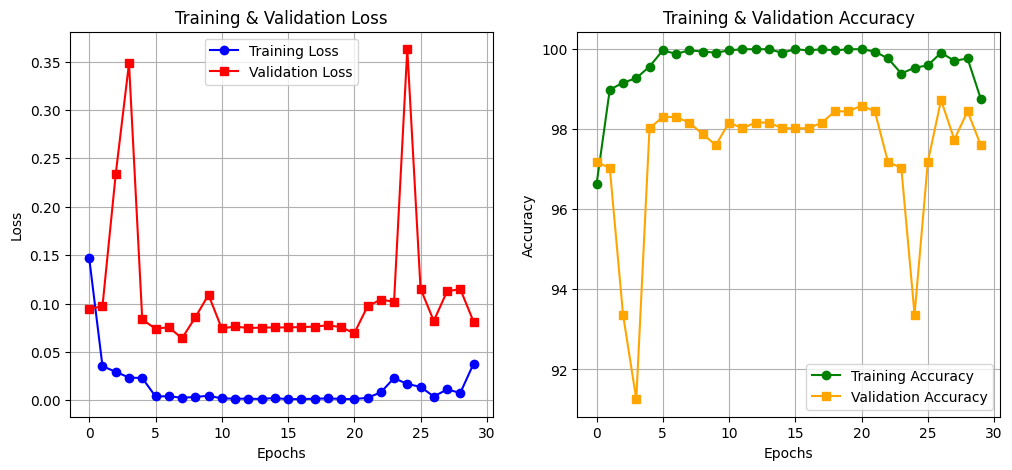

In [54]:
plottting3=plotting(history3)


Evaluating model with Validation loader.

Overall Accuracy: 97.60%
Overall Error Rate: 2.40%
F1-Score (Macro-Averaged): 97.68%
F1-Score (Weighted): 97.60%
Matthews Correlation Coefficient (MCC): 97.21%
Cohen’s Kappa Score: 97.20%
Top-1 Accuracy (%): 97.60%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.041151 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108         100.00       95.50         97.70           100.00
 BRRI_28          97.80       98.89         98.34            99.68
 BRRI_29          93.97       98.20         96.04            98.83
 BRRI_34          98.06       94.39         96.19            99.67
 BRRI_50          98.80      100.00         99.39            99.84
 BRRI_74          99.07       99.07         99.07            99.83
    BR_5          96.12       98.02         97.06            99.34

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                111
 BRR

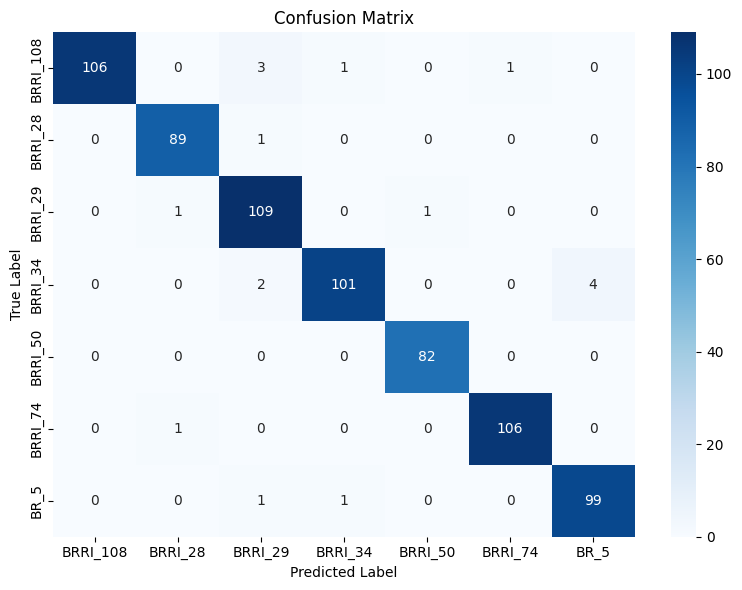

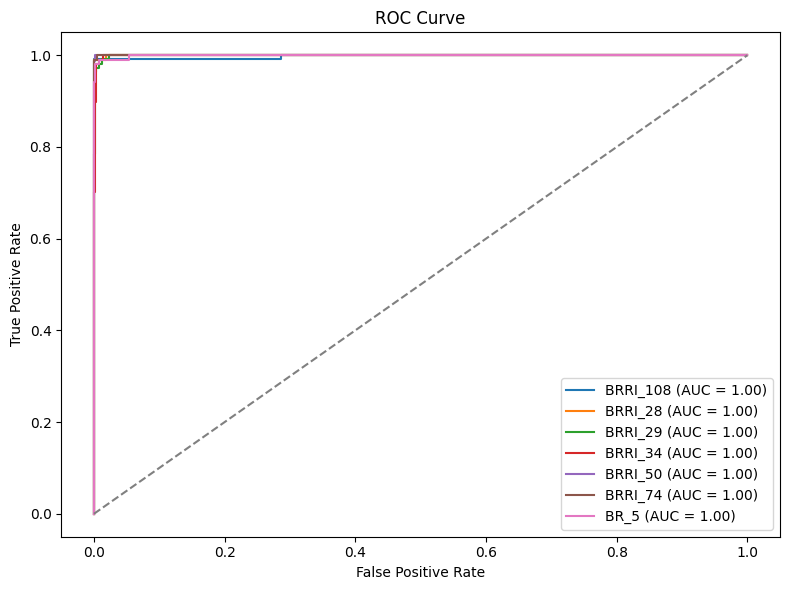

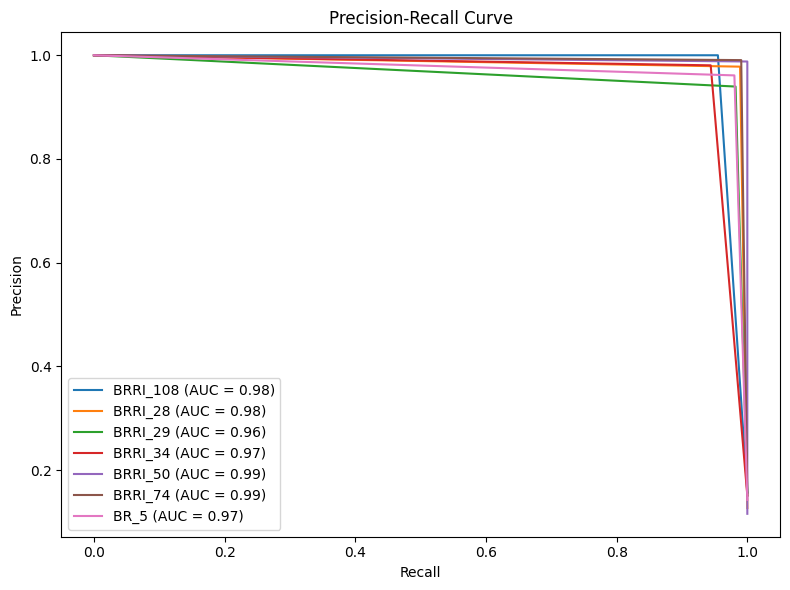


Evaluating model with Testing loader.

Overall Accuracy: 97.12%
Overall Error Rate: 2.88%
F1-Score (Macro-Averaged): 97.14%
F1-Score (Weighted): 97.13%
Matthews Correlation Coefficient (MCC): 96.66%
Cohen’s Kappa Score: 96.63%
Top-1 Accuracy (%): 97.12%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.044781 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          97.30       92.31         94.74            99.51
 BRRI_28          99.15       97.50         98.32            99.84
 BRRI_29          89.32      100.00         94.36            98.27
 BRRI_34         100.00       94.50         97.17           100.00
 BRRI_50          99.07       98.15         98.60            99.84
 BRRI_74          97.85      100.00         98.91            99.69
    BR_5          96.81       98.91         97.85            99.53

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                117
 BRRI_2

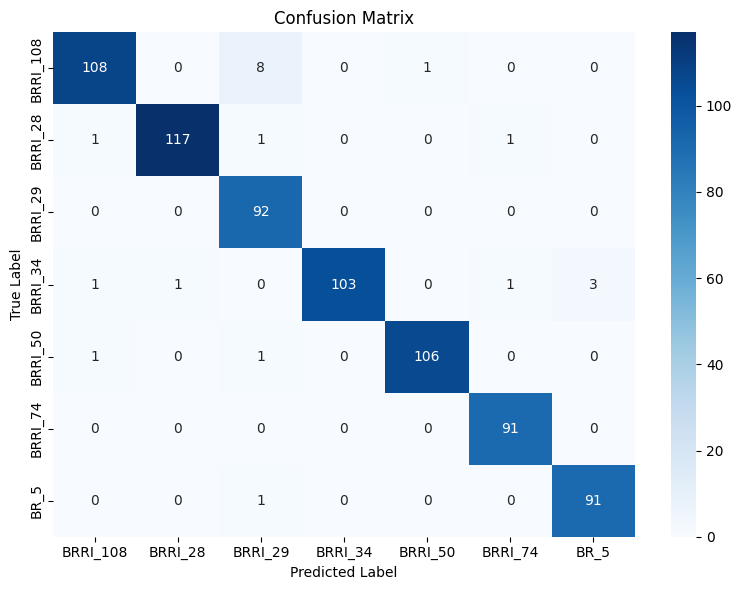

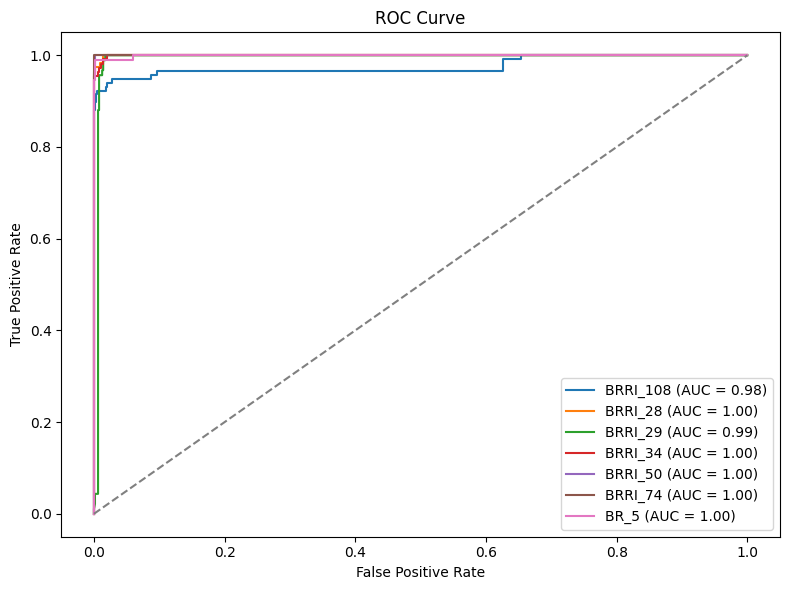

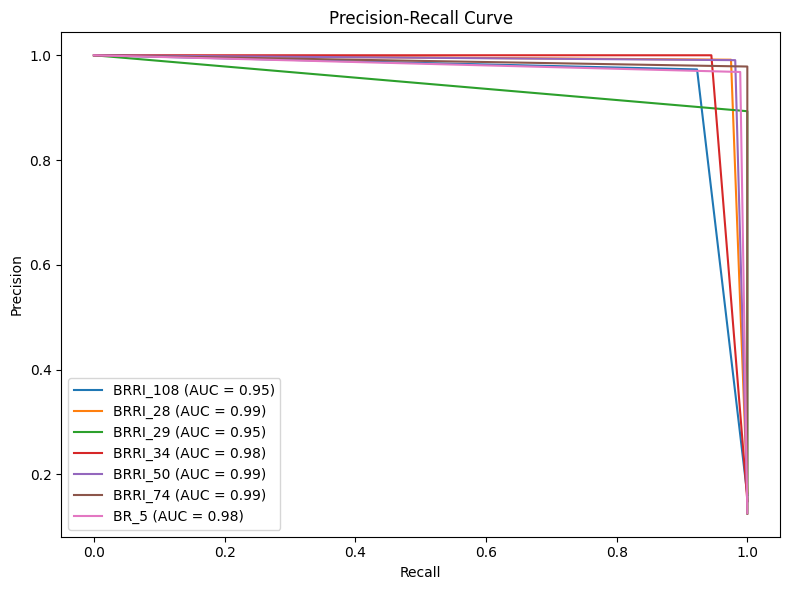

Training metrics logged to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/logs/swin_tiny_training_metrics_3.json
Model saved to /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/swin_tiny/swin_tiny_3.pth
Evaluation metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/swin_tiny_evaluation_metrics_3.json
Class-wise metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/swin_tiny_class_wise_metrics_3.csv


In [52]:
def evaluate_model(model, dataloader, class_names, top_k=(1, 5), loader_name="Validation"):
    print(f"\nEvaluating model with {loader_name} loader.")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    top_k_correct = {k: 0 for k in top_k}
    total_samples = 0
    start_time = time.time()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Apply pooling if model output is sequence-shaped (e.g., Swin Tiny)
            if outputs.dim() == 3:
                outputs = torch.mean(outputs, dim=1)

            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            top_k_preds = torch.topk(outputs, max(top_k), dim=1).indices.cpu().numpy()

            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for k in top_k:
                correct_top_k = np.sum(
                    labels.cpu().numpy().reshape(-1, 1) == top_k_preds[:, :k]
                )
                top_k_correct[k] += correct_top_k

            total_samples += labels.size(0)

    inference_time = time.time() - start_time
    avg_inference_time = inference_time / total_samples

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    from sklearn.metrics import (
        confusion_matrix, f1_score, roc_auc_score, roc_curve, auc,
        matthews_corrcoef, cohen_kappa_score, precision_recall_curve
    )
    from sklearn.preprocessing import label_binarize
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    cm = confusion_matrix(all_labels, all_preds)
    accuracy = np.trace(cm) / np.sum(cm) * 100
    error_rate = 100 - accuracy
    precision = np.diag(cm) / np.where(np.sum(cm, axis=0) == 0, 1, np.sum(cm, axis=0)) * 100
    recall = np.diag(cm) / np.where(np.sum(cm, axis=1) == 0, 1, np.sum(cm, axis=1)) * 100
    tn = np.sum(cm) - (np.sum(cm, axis=1) + np.sum(cm, axis=0) - np.diag(cm))
    fp = np.sum(cm, axis=0) - np.diag(cm)
    specificity = tn / np.where((tn + fp) == 0, 1, (tn + fp)) * 100

    f1_macro = f1_score(all_labels, all_preds, average="macro") * 100
    f1_weighted = f1_score(all_labels, all_preds, average="weighted") * 100
    f1_per_class = f1_score(all_labels, all_preds, average=None) * 100
    mcc = matthews_corrcoef(all_labels, all_preds) * 100
    kappa = cohen_kappa_score(all_labels, all_preds) * 100

    n_classes = len(class_names) if class_names is not None else np.max(all_labels) + 1
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]

    if n_classes > 1:
        all_labels_binarized = label_binarize(all_labels, classes=np.arange(n_classes))
        roc_auc = roc_auc_score(all_labels_binarized, all_probs, multi_class="ovr") * 100
    else:
        roc_auc = None

    top_k_accuracy = {f"Top-{k} Accuracy (%)": (top_k_correct[k] / total_samples) * 100 for k in top_k}

    unique_classes, support = np.unique(all_labels, return_counts=True)
    support_df = pd.DataFrame({
        "Class": class_names,
        "Support (Samples)": support
    })

    metrics_df = pd.DataFrame({
        "Class": class_names,
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1_per_class,
        "Specificity (%)": specificity
    }).round(2)

    print(f"\nOverall Accuracy: {accuracy:.2f}%")
    print(f"Overall Error Rate: {error_rate:.2f}%")
    print(f"F1-Score (Macro-Averaged): {f1_macro:.2f}%")
    print(f"F1-Score (Weighted): {f1_weighted:.2f}%")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}%")
    print(f"Cohen’s Kappa Score: {kappa:.2f}%")
    for k, acc in top_k_accuracy.items():
        print(f"{k}: {acc:.2f}%")
    print(f"\nAverage Inference Time per Image: {avg_inference_time:.6f} seconds")
    print("\nClass-Wise Performance Metrics:")
    print(metrics_df.to_string(index=False))
    print("\nClass-Wise Sample Distribution:")
    print(support_df.to_string(index=False))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    if roc_auc is not None:
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
            roc_auc_val = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc_val:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 6))
    for class_idx, class_name in enumerate(class_names):
        y_true = (all_labels == class_idx).astype(int)
        y_scores = (all_preds == class_idx).astype(int)
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall_curve, precision_curve)
        plt.plot(recall_curve, precision_curve, label=f"{class_name} (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": round(accuracy, 2),
        "error_rate": round(error_rate, 2),
        "f1_macro": round(f1_macro, 2),
        "f1_weighted": round(f1_weighted, 2),
        "roc_auc": round(roc_auc, 2) if roc_auc is not None else "N/A",
        "mcc": round(mcc, 2),
        "kappa": round(kappa, 2),
        "top_k_accuracy": top_k_accuracy,
        "avg_inference_time": avg_inference_time,
        "class_metrics": metrics_df.to_dict(orient="records"),
        "class_support": support_df.to_dict(orient="records")
    }


metrics3=evaluate_model(model3, val_loader, class_names=dataset.classes, loader_name="Validation")
metrics3=evaluate_model(model3, test_loader, class_names=dataset.classes, loader_name="Testing")
save_model_artifacts(model=model3,history=history3,metrics=metrics3,model_name="swin_tiny",version="3")

Merged 60 epochs of training.


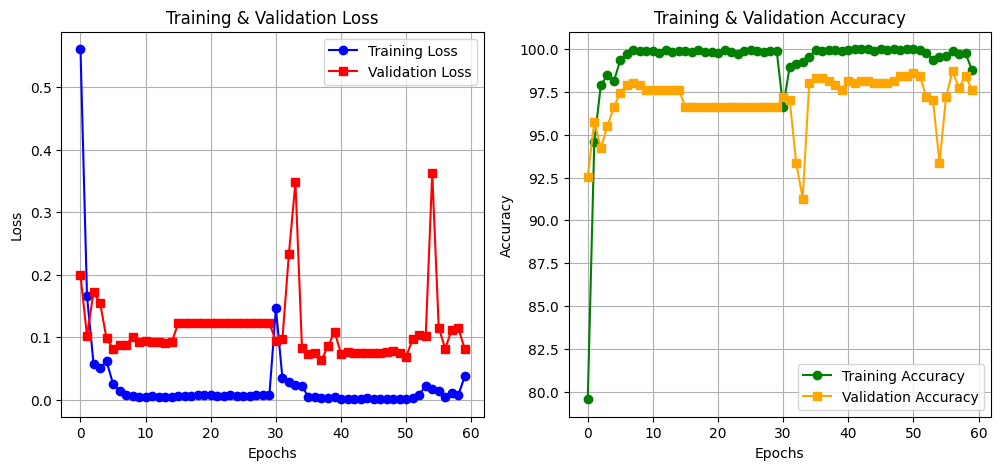

In [57]:
def merge_histories_and_plot(history1, history2, history3):
    """
    Merges three training history dictionaries and plots the combined training and validation curves.

    Args:
        history1, history2, history3: Dictionaries with keys "train_loss", "train_acc", "val_loss", "val_acc"
    """
    merged_history = {
        "train_loss": history1["train_loss"] + history2["train_loss"] + history3["train_loss"],
        "train_acc": history1["train_acc"] + history2["train_acc"] + history3["train_acc"],
        "val_loss": history1["val_loss"] + history2["val_loss"] + history3["val_loss"],
        "val_acc": history1["val_acc"] + history2["val_acc"] + history3["val_acc"]
    }

    print(f"Merged {len(history1['train_loss']) + len(history2['train_loss']) + len(history3['train_loss'])} epochs of training.")
    plotting(merged_history)
    return merged_history

final_history = merge_histories_and_plot(history1, history2, history3)